### Collect data out of MongoDB and Chroma DB

In [70]:
import os
import pymongo
import pandas as pd
from dotenv import load_dotenv
# import torch
import chromadb
# from PIL import Image
# from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO
from tqdm import tqdm

load_dotenv()

True

In [71]:
#no user warnins
import warnings
warnings.filterwarnings('ignore')

In [72]:
client = pymongo.MongoClient(os.getenv('MONGO_CONNECTION_STRING'))
db = client["monin"]
collection = db["drinks"]

In [73]:
collection.find({})[0]

{'_id': ObjectId('67cdeca2d61baaa7449cc9f0'),
 'name': 'Hawaiian Pearl Bubble Tea',
 'recipie': ['30 mL Monin Hawaiian Island Syrup',
  '150 mL tea',
  '60 mL club soda',
  '45 mL tapioca bobas',
  'Fill serving glass full of ice.',
  'Pour ingredients into serving glass in order listed.',
  'Stir gently to mix.',
  'Add garnish and serve.'],
 'category': 'bubble_teas',
 'image_url': 'https://monin.blob.core.windows.net/recipe/images/mrd/drink/5125b732-6dea-4287-a76e-fdb0588dc394-2.png',
 'drink_url': 'https://monin.us/products/hawaiian-pearl-bubble-tea',
 'taste': ['Citrusy', 'Sour']}

In [74]:
collection.count_documents({})

2004

In [12]:
chroma_client_remote = chromadb.HttpClient(host=os.environ.get('CHROMA_URL'), port=8000,
                         settings=chromadb.config.Settings(
                            chroma_client_auth_provider="chromadb.auth.token_authn.TokenAuthClientProvider", 
                            chroma_client_auth_credentials=os.environ.get('CHROMA_TOKEN')
                         ))

collection_text = chroma_client_remote.get_or_create_collection(name="drinks_text")
collection_image = chroma_client_remote.get_or_create_collection(name="drinks_image")
collection_combined = chroma_client_remote.get_or_create_collection(name="drinks_combined")

local_text_data = collection_text.get(include=["embeddings", "uris", "documents", "metadatas"])
local_image_data = collection_image.get(include=["embeddings", "uris", "documents", "metadatas"])
local_combined_data = collection_combined.get(include=["embeddings", "uris", "documents", "metadatas"])



In [20]:
print(len(local_text_data['ids']))

2004
2004


In [22]:
# output few records
print(local_image_data)

{'ids': ['67cdeca2d61baaa7449cc9f0', '67cdeca4d61baaa7449cc9f1', '67cdeca6d61baaa7449cc9f2', '67cdeca8d61baaa7449cc9f3', '67cdecabd61baaa7449cc9f4', '67cdecadd61baaa7449cc9f5', '67cdecafd61baaa7449cc9f6', '67cdecb1d61baaa7449cc9f7', '67cdecb4d61baaa7449cc9f8', '67cdecb6d61baaa7449cc9f9', '67cdecb8d61baaa7449cc9fa', '67cdecbad61baaa7449cc9fb', '67cdecbcd61baaa7449cc9fc', '67cdecbed61baaa7449cc9fd', '67cdecc0d61baaa7449cc9fe', '67cdecc2d61baaa7449cc9ff', '67cdecc5d61baaa7449cca00', '67cdecc6d61baaa7449cca01', '67cdecc9d61baaa7449cca02', '67cdeccbd61baaa7449cca03', '67cdeccdd61baaa7449cca04', '67cdeccfd61baaa7449cca05', '67cdecd3d61baaa7449cca06', '67cdecd5d61baaa7449cca07', '67cdecd7d61baaa7449cca08', '67cdecd9d61baaa7449cca09', '67cdecdbd61baaa7449cca0a', '67cdecddd61baaa7449cca0b', '67cdecdfd61baaa7449cca0c', '67cdece1d61baaa7449cca0d', '67cdece3d61baaa7449cca0e', '67cdece5d61baaa7449cca0f', '67cdece7d61baaa7449cca10', '67cdece9d61baaa7449cca11', '67cdecebd61baaa7449cca12', '67cdecedd6

In [75]:
data = list(collection.find({}))
df = pd.DataFrame(data)

# If available, load your embeddings from chromadb (assuming they match the same order as your df)
# For example, after retrieving the embeddings:
df['text_embeds'] = list(local_text_data['embeddings'])
df['image_embeds'] = list(local_image_data['embeddings'])

In [76]:
df['combined_embeds'] = list(local_combined_data['embeddings'])

In [77]:
df.head()

,_id,name,recipie,category,image_url,drink_url,taste,text_embeds,image_embeds,combined_embeds
0,67cdeca2d61baaa7449cc9f0,Hawaiian Pearl Bubble Tea,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/hawaiian-pearl-bubbl...,"[Citrusy, Sour]","[-0.2425253838300705, -0.03239031136035919, -0...","[-0.271756649017334, 0.7865740656852722, -0.12...","[-0.2425253838300705, -0.03239031136035919, -0..."
1,67cdeca4d61baaa7449cc9f1,Blue Bubble Milk Tea,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/blue-bubble-milk-tea,"[Floral, Salty, Sweet]","[-0.1409539431333542, -0.08377346396446228, 0....","[0.13253293931484222, 0.3377094864845276, -0.1...","[-0.1409539431333542, -0.08377346396446228, 0...."
2,67cdeca6d61baaa7449cc9f2,Strawberry Bubble Burst Tea,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/strawberry-bubble-bu...,"[Fruity, Floral, Sweet, Bitter]","[-0.15835341811180115, 0.0019426532089710236, ...","[-0.25111329555511475, 0.8149627447128296, -0....","[-0.15835341811180115, 0.0019426532089710236, ..."
3,67cdeca8d61baaa7449cc9f3,Bubble Chai Tea,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/bubble-chai-tea,"[Sweet, Creamy]","[-0.129270538687706, -0.0847550630569458, 0.08...","[0.051974114030599594, 0.3284218907356262, -0....","[-0.129270538687706, -0.0847550630569458, 0.08..."
4,67cdecabd61baaa7449cc9f4,Golden Jelly Bubble Tea,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...",bubble_teas,https://monin.blob.core.windows.net/recipe/ima...,https://monin.us/products/golden-jelly-bubble-tea,"[Floral, Salty, Bitter, Floral]","[-0.2102978527545929, -0.07430075109004974, 0....","[-0.3368239104747772, 0.9911291599273682, -0.2...","[-0.2102978527545929, -0.07430075109004974, 0...."


### Initial exploration

In [30]:
df_exploded = df.explode('taste')
df_exploded['taste'].value_counts()

taste
Sweet         1420
Sour          1337
Floral        1278
Citrusy        650
Spicy          592
Umami          492
Tart           433
Bitter         387
Fruity         383
Creamy         349
Salty          278
Herbal         204
Rich           124
Milky           15
Light           12
Refreshing      10
Earthy           6
Name: count, dtype: int64

### EDA

#### Class & Flavor Distribution

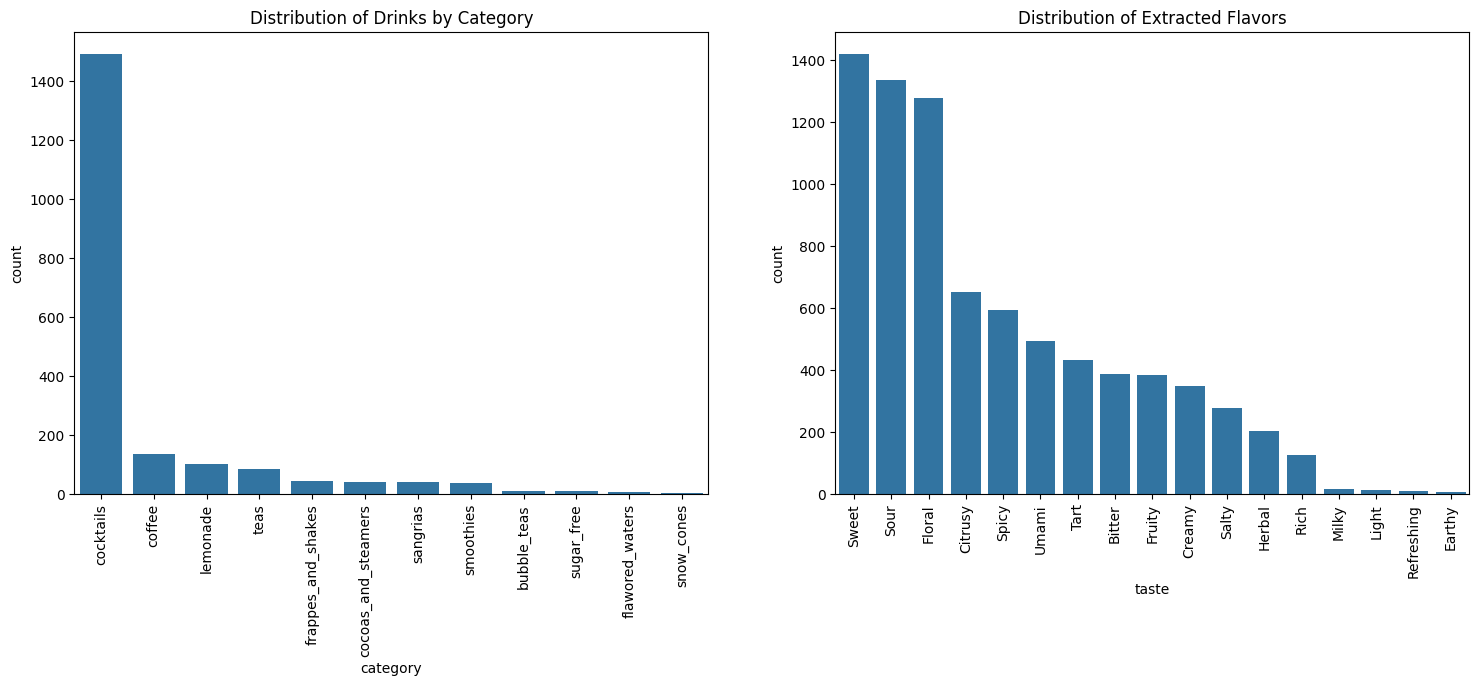

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(data=df, x='category', order=df['category'].value_counts().index, ax=axs[0])
axs[0].set_title('Distribution of Drinks by Category')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

# plot flavor distribution
sns.countplot(data=df_exploded, x='taste', order=df_exploded['taste'].value_counts().index, ax=axs[1])
axs[1].set_title('Distribution of Extracted Flavors')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


The category distribution is skewed, with 'cocktails' being much more represented than other categories. The flavor distribution is also skewed, with 'Sweet', 'Sour', and 'FLoral' being the most common flavors, although not as skewed as the category distribution.

#### Category vs. Flavor

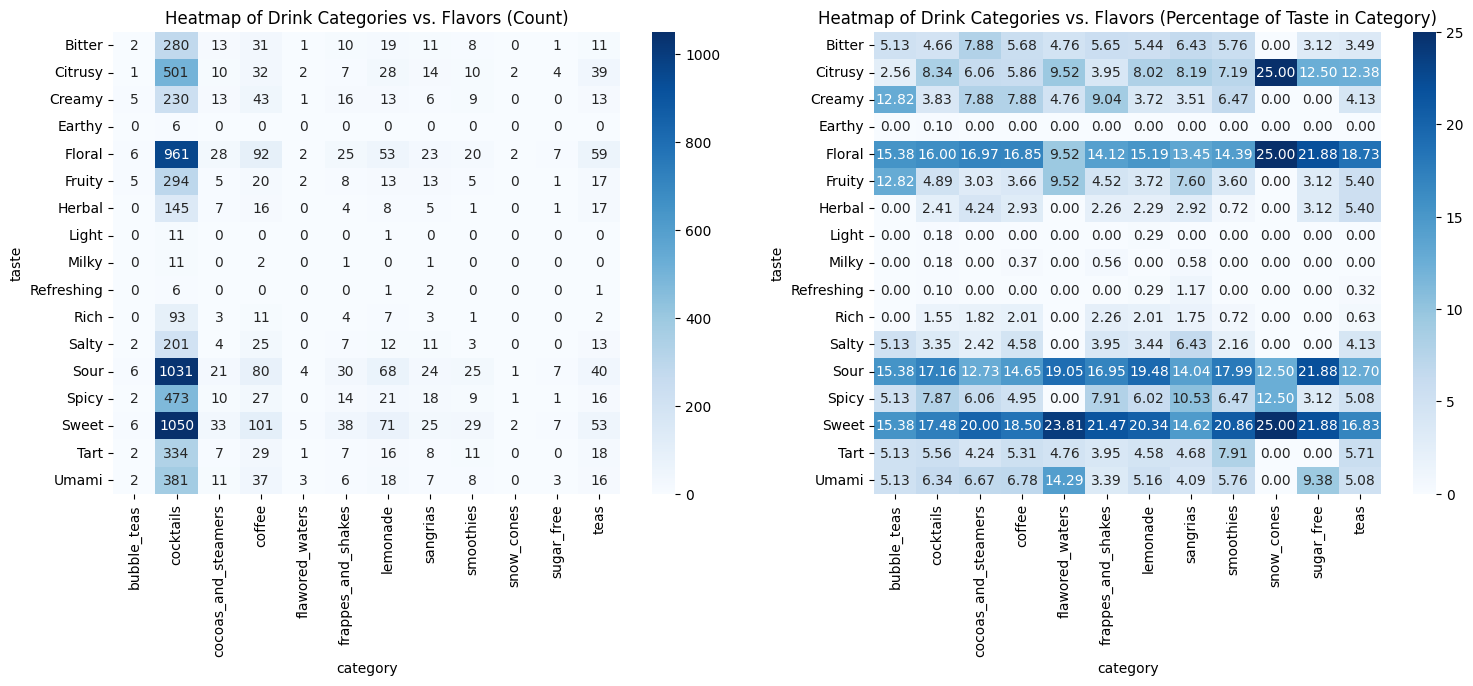

In [61]:
pivot = df_exploded.pivot_table(index='taste', columns='category', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=0), axis=1) * 100

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Heatmap of Drink Categories vs. Flavors (Count)')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)

sns.heatmap(pivot_percentage, annot=True, fmt='.2f', cmap='Blues', ax=axs[1])
axs[1].set_title('Heatmap of Drink Categories vs. Flavors (Percentage of Taste in Category)')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
plt.show()


We can see, that some flavors are being picked for all categories more often, such as 'Sweet', 'Sour', 'Floral', while some are continuosely being choosed less often, such as 'Light', 'Milky' and 'Refreshing'. We can also notice, that some categories have a flavor that is being picked more often than in other categories, such as 'Sour' in 'sugar free' category, 'Sweet', 'Floral' and 'Citrusy' for 'snow_cones', and 'Creamy' for 'bubble_teas'.

#### Distribution of quantity of extracted flavors

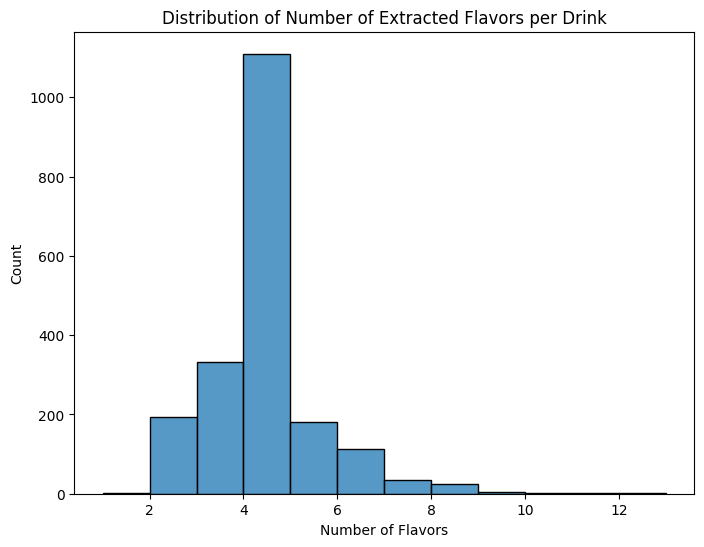

In [62]:
# Calculate number of flavors per drink
df['num_tastes'] = df['taste'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(8, 6))
sns.histplot(df['num_tastes'], bins=range(1, df['num_tastes'].max()+2), kde=False)
plt.title('Distribution of Number of Extracted Flavors per Drink')
plt.xlabel('Number of Flavors')
plt.ylabel('Count')
plt.show()


The distribution seems to be close to normal, with most drinks having around 4-5 flavors extracted.

#### t-SNE Visualization of Embeddings

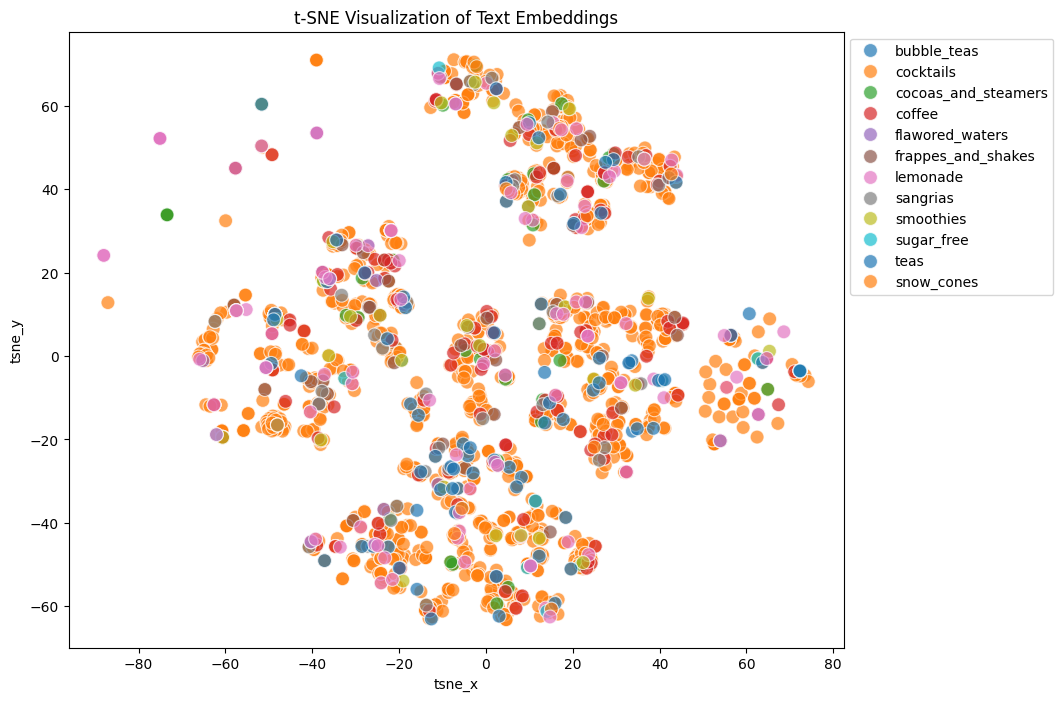

In [63]:
from sklearn.manifold import TSNE
import numpy as np

# Convert embedding list to array
embeds = np.array(list(df['text_embeds']))  # or use 'combined_embeds' if you concatenated

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Text Embeddings')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


Text embeddings seem to have some clusters, although they do not correlate with category. This may indicate that ingredients and process of preparation may be the same for different categories, and it is important to investigate these clusters further.

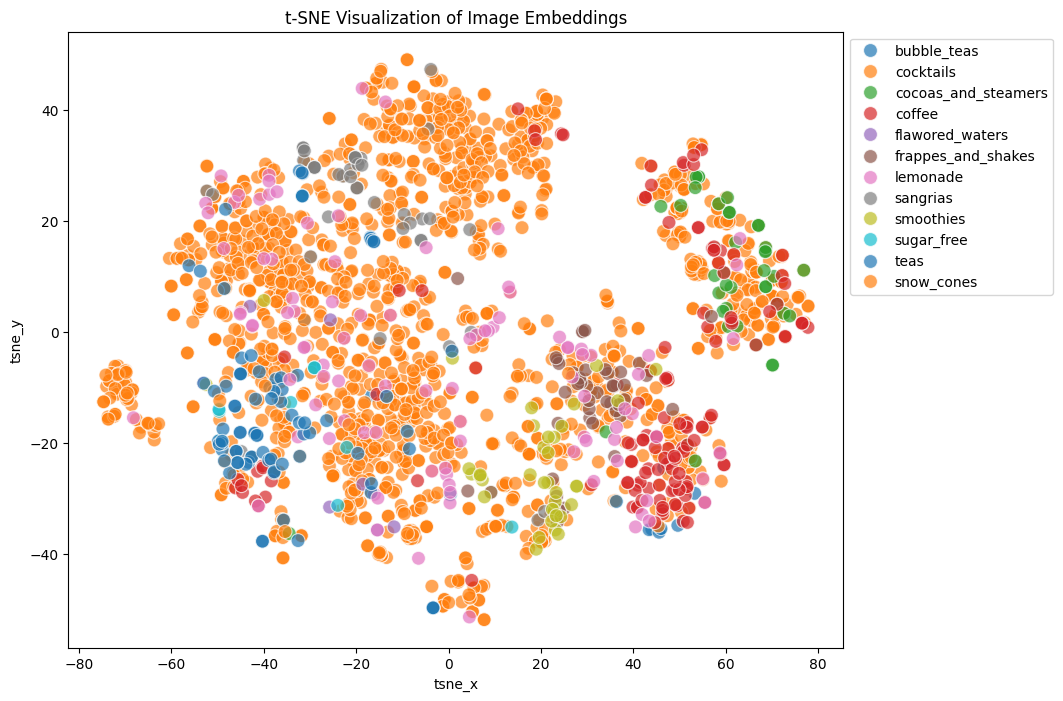

In [64]:
# now the same for image embeddings and combined embeddings
# Convert embedding list to array
embeds = np.array(list(df['image_embeds']))  # or use 'combined_embeds' if you concatenated

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Image Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()


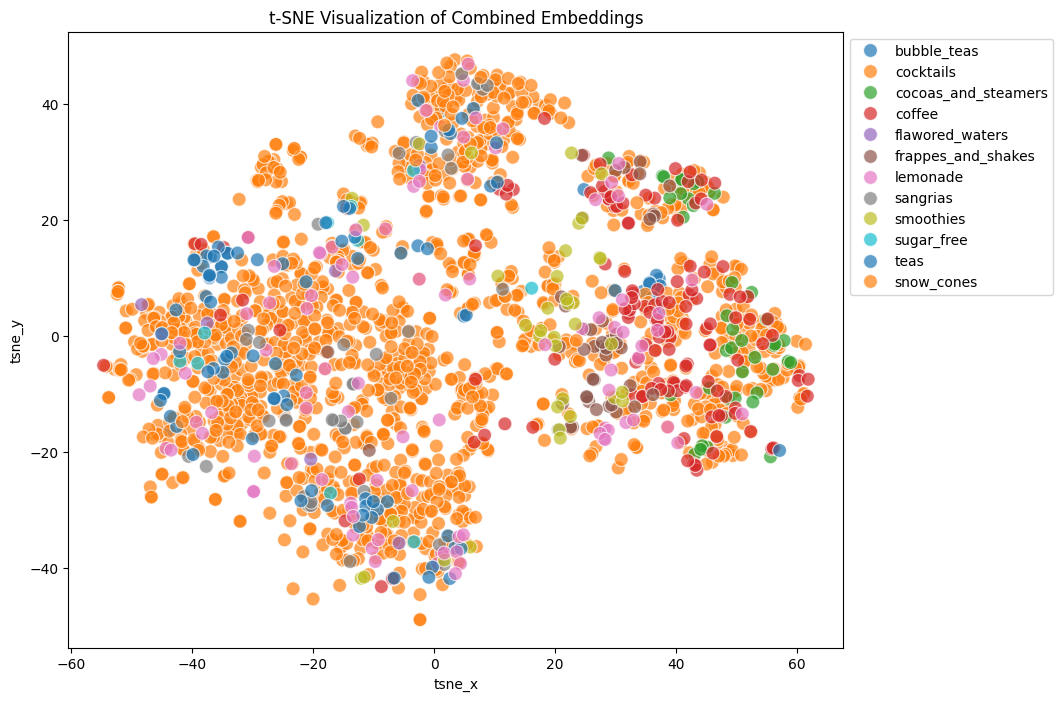

In [65]:
# Convert embedding list to array
embeds = np.array(list(df['combined_embeds']))  # or use 'combined_embeds' if

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)

# Store t-SNE results in the dataframe
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='category', data=df, palette="tab10", s=100, alpha=0.7)
plt.title('t-SNE Visualization of Combined Embeddings')

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The clusters of image and common embeddings seem to be even more broad and not correlating with the category. This may indicate that the images and text are not very informative for analysing the taste of the drink. 
But, interestingly, some categories have a clear cluster, such as 'coffe', 'smoothies' and 'bubble teas'. This may indicate that these categories have a clear visual representation that is different from other categories.

#### Analyzing ingredients and recipes

In [79]:
import re
import pandas as pd

# Define a list of common measurement units
measurement_units = ['mL', 'L', 'g', 'kg', 'tsp', 'tbsp', 'cup', 'oz']

def is_ingredient(item):
    # Check if the item contains any of the measurement units using regex
    pattern = r'\d+\s*(' + '|'.join(measurement_units) + r')'
    return re.search(pattern, item, re.IGNORECASE) is not None

def split_recipe(recipe_list):
    ingredients = []
    steps = []
    for item in recipe_list:
        # Use the heuristic: if it contains a measurement unit, consider it an ingredient.
        if is_ingredient(item):
            ingredients.append(item)
        else:
            steps.append(item)
    return pd.Series([ingredients, steps])


# Apply the function to create two new columns
df[['ingredients', 'steps']] = df['recipie'].apply(split_recipe)

# Display the results
df[['ingredients', 'steps', 'recipie']].head()


,ingredients,steps,recipie
0,"[30 mL Monin Hawaiian Island Syrup, 150 mL tea...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Hawaiian Island Syrup, 150 mL tea..."
1,"[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL..."
2,"[30 mL Monin Strawberry Purée, 15 mL fresh lem...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Strawberry Purée, 15 mL fresh lem..."
3,"[30 mL Monin Chai Tea Concentrate, 210 mL milk...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Chai Tea Concentrate, 210 mL milk..."
4,"[30 mL Monin Golden Turmeric Syrup, 120 mL bla...","[Fill serving glass full of ice., Pour ingredi...","[30 mL Monin Golden Turmeric Syrup, 120 mL bla..."


In [95]:
# also make an ingredients column without measurement units
def split_recipe_ingredients(recipe_list):
    ingredients = []
    for item in recipe_list:
        if is_ingredient(item):
            pattern = r'(\d+(\s+\d+\/\d+)?\s*(' + '|'.join(measurement_units) + r'))'
            ingredients.append(re.sub(pattern, '', item).strip())

            # ingredients.append(re.sub(r'\d+\s*(' + '|'.join(measurement_units) + r')', '', item).strip())
    return ingredients
df['ingredients_no_units'] = df['ingredients'].apply(split_recipe_ingredients)
df[['ingredients_no_units', 'ingredients']].head()

,ingredients_no_units,ingredients
0,"[Monin Hawaiian Island Syrup, tea, club soda, ...","[30 mL Monin Hawaiian Island Syrup, 150 mL tea..."
1,"[Monin Lavender Syrup, tea, milk, tapioca bobas]","[30 mL Monin Lavender Syrup, 120 mL tea, 90 mL..."
2,"[Monin Strawberry Purée, fresh lemon juice, te...","[30 mL Monin Strawberry Purée, 15 mL fresh lem..."
3,"[Monin Chai Tea Concentrate, milk, tapioca bobas]","[30 mL Monin Chai Tea Concentrate, 210 mL milk..."
4,"[Monin Golden Turmeric Syrup, black tea, milk,...","[30 mL Monin Golden Turmeric Syrup, 120 mL bla..."


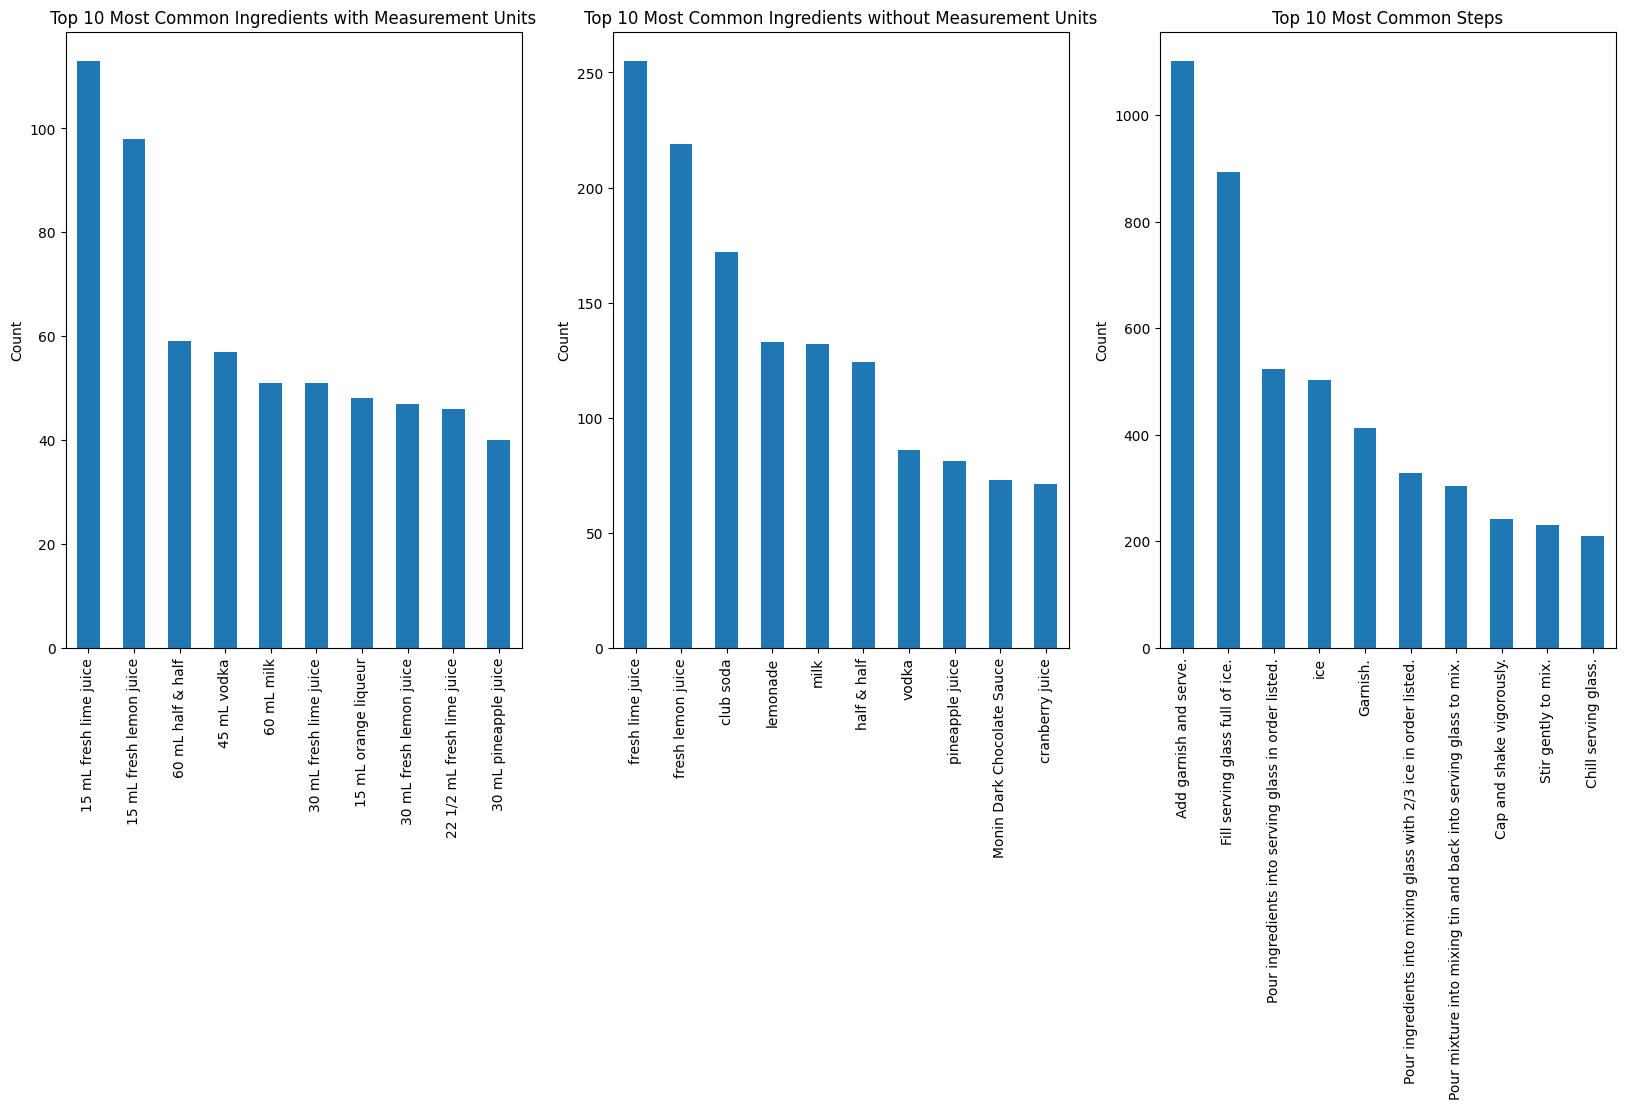

In [96]:
# plot two plots for ingredients and steps
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# plot ingredients
all_ingredients = [item for sublist in df['ingredients'] for item in sublist]
ingredient_counts = pd.Series(all_ingredients).value_counts()
ingredient_counts.head(10).plot(kind='bar', ax=axs[0])
axs[0].set_title('Top 10 Most Common Ingredients with Measurement Units')
axs[0].set_ylabel('Count')

# plot ingredients without units
all_ingredients_no_units = [item for sublist in df['ingredients_no_units'] for item in sublist]
ingredient_counts_no_units = pd.Series(all_ingredients_no_units).value_counts()
ingredient_counts_no_units.head(10).plot(kind='bar', ax=axs[1])
axs[1].set_title('Top 10 Most Common Ingredients without Measurement Units')
axs[1].set_ylabel('Count')

# plot steps
all_steps = [item for sublist in df['steps'] for item in sublist]
step_counts = pd.Series(all_steps).value_counts()
step_counts.head(10).plot(kind='bar', ax=axs[2])
axs[2].set_title('Top 10 Most Common Steps')
axs[2].set_ylabel('Count')

plt.show()



In [97]:
# output as a table for better readability
print("Top 10 Most Common Ingredients with Measurement Units")
print(ingredient_counts.head(20))

print("\nTop 10 Most Common Ingredients without Measurement Units")
print(ingredient_counts_no_units.head(20))

print("\nTop 10 Most Common Steps")
print(step_counts.head(20))


Top 10 Most Common Ingredients with Measurement Units
15 mL fresh lime juice              113
15 mL fresh lemon juice              98
60 mL half & half                    59
45 mL vodka                          57
60 mL milk                           51
30 mL fresh lime juice               51
15 mL orange liqueur                 48
30 mL fresh lemon juice              47
22 1/2 mL fresh lime juice           46
30 mL pineapple juice                40
45 mL silver tequila                 40
15 mL Monin Dark Chocolate Sauce     40
22 1/2 mL fresh lemon juice          35
210 mL lemonade                      33
180 mL club soda                     33
30 mL half & half                    32
60 mL club soda                      29
60 mL cranberry juice                26
45 mL gin                            25
210 mL fresh brewed tea              25
Name: count, dtype: int64

Top 10 Most Common Ingredients without Measurement Units
fresh lime juice               255
fresh lemon juice          

In [105]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [127]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import community.community_louvain as community_louvain

# -----------------------------
# Build or load your co-occurrence graph G
# -----------------------------
co_occurrence = defaultdict(int)
for ingredients_list in df['ingredients_no_units']:
    unique_ingredients = list(set(ingredients_list))
    for i in range(len(unique_ingredients)):
        for j in range(i + 1, len(unique_ingredients)):
            pair = tuple(sorted([unique_ingredients[i], unique_ingredients[j]]))
            co_occurrence[pair] += 1

co_df = pd.DataFrame([
    {'ingredient1': pair[0], 'ingredient2': pair[1], 'count': count}
    for pair, count in co_occurrence.items()
])

threshold = 5
co_df_filtered = co_df[co_df['count'] >= threshold]

G = nx.Graph()
for _, row in co_df_filtered.iterrows():
    ing1, ing2, weight = row['ingredient1'], row['ingredient2'], row['count']
    G.add_edge(ing1, ing2, weight=weight)

# -----------------------------
# Compute community partition
# -----------------------------
partition = community_louvain.best_partition(G)

# Optional: compute node sizes based on degree or frequency
degrees = dict(G.degree())
node_sizes = {node: degrees[node] * 5 for node in G.nodes()}  # smaller multiplier for PyVis

# -----------------------------
# Build PyVis Network
# -----------------------------
net = Network(
    height="2000px",
    # height="100%",
    width="100%",
    bgcolor="#222222",   # background color
    font_color="white"
)

# ForceAtlas2 is a nice layout for co-occurrence networks
net.force_atlas_2based()

import random
import colorsys

num_communities = len(set(partition.values()))
# Generate random distinct colors
def random_color():
    h, s, v = random.random(), 0.6 + random.random()*0.4, 0.9
    r, g, b = [int(256*i) for i in colorsys.hsv_to_rgb(h, s, v)]
    return f'rgb({r},{g},{b})'

community_colors = {c: random_color() for c in set(partition.values())}

# Add nodes with color, size, label
for node in G.nodes():
    comm = partition[node]
    net.add_node(
        n_id=node,
        label=node,
        size=node_sizes[node],
        color=community_colors[comm]
    )

# Add edges with weight as the "value" (used for thickness in PyVis)
for u, v, data in G.edges(data=True):
    net.add_edge(u, v, value=data['weight'])

# Generate and show the network
net.show("co_occurrence.html", notebook=False)


co_occurrence.html


The size of the node reflects its degree—in other words, how many connections (co-occurrences) that ingredient has with others. 

We can notice, that most versatile ingredients are 'fresh lemon juice', 'fresh lime juice', 'club soda', 'half & half' and 'milk'. These ingredients are used in a lot of recipes and are connected to a lot of other ingredients.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sasha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


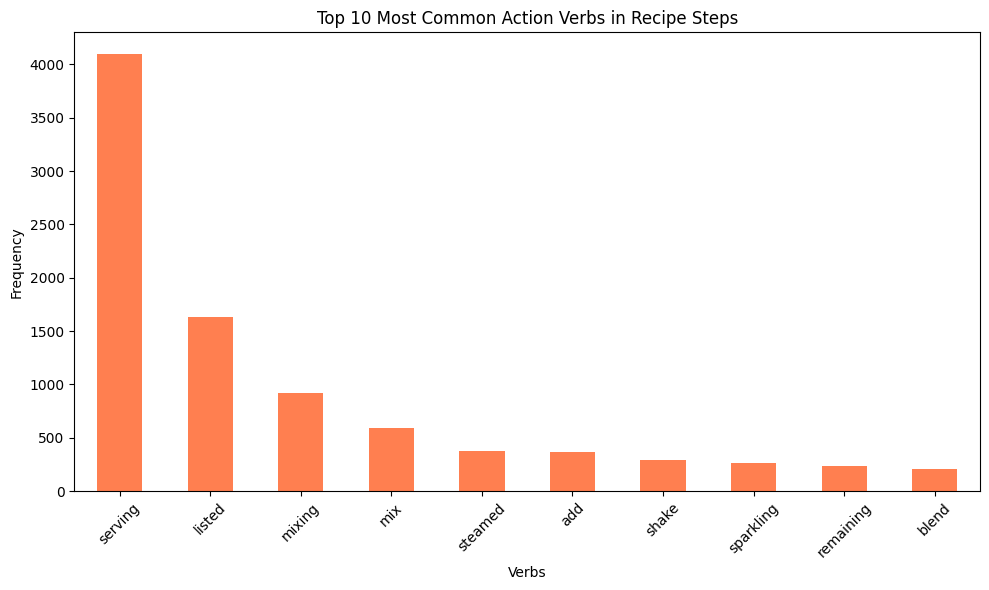

In [130]:
# -------------------------------
# 4. Step Analysis: Extracting Common Action Verbs
# -------------------------------
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def extract_verbs(text):
    # Tokenize and tag part-of-speech
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    # Extract verbs (tags that start with 'VB')
    verbs = [word.lower() for word, tag in tagged if tag.startswith('VB')]
    return verbs

all_verbs = []
for steps in df['steps']:
    for step in steps:
        all_verbs.extend(extract_verbs(step))
        
verb_counts = pd.Series(all_verbs).value_counts()

plt.figure(figsize=(10, 6))
verb_counts.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Most Common Action Verbs in Recipe Steps')
plt.ylabel('Frequency')
plt.xlabel('Verbs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Initial clustering of recipes based on embeddings

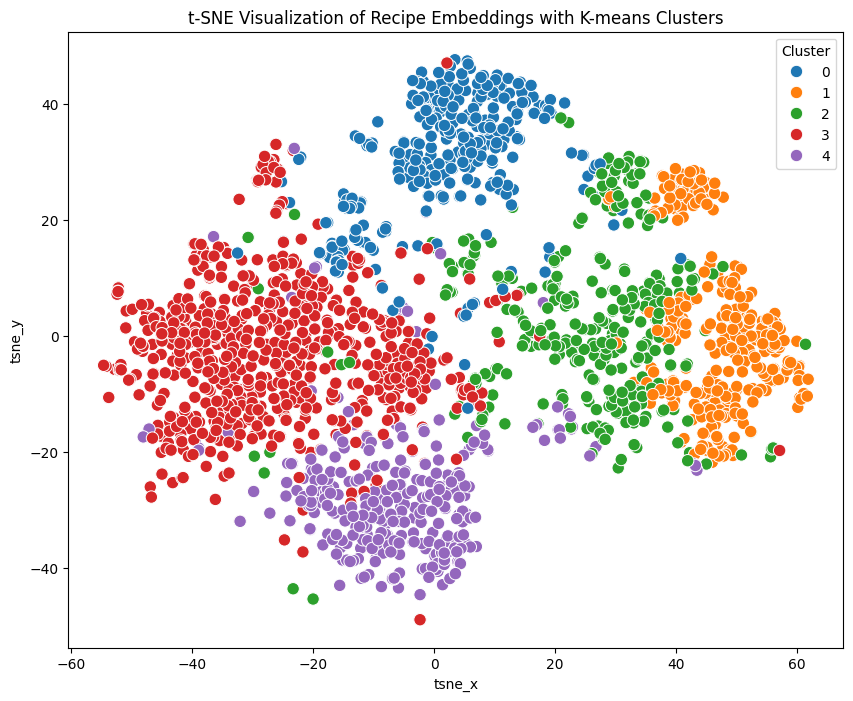

In [131]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume 'combined_embeds' column contains concatenated embeddings for each recipe
embeds = np.array(list(df['combined_embeds']))

# Determine number of clusters (e.g., k=5) via silhouette score or domain knowledge
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(embeds)
df['cluster'] = clusters

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', s=80)
plt.title('t-SNE Visualization of Recipe Embeddings with K-means Clusters')
plt.legend(title='Cluster')
plt.show()


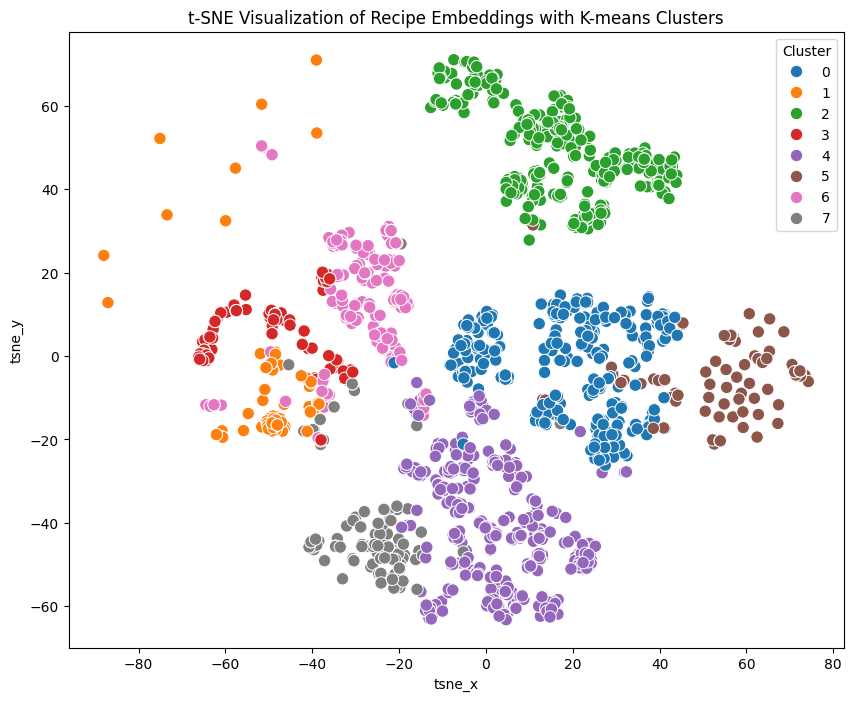

In [133]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume 'combined_embeds' column contains concatenated embeddings for each recipe
embeds = np.array(list(df['text_embeds']))

# Determine number of clusters (e.g., k=5) via silhouette score or domain knowledge
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(embeds)
df['cluster'] = clusters

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeds)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', s=80)
plt.title('t-SNE Visualization of Recipe Embeddings with K-means Clusters')
plt.legend(title='Cluster')
plt.show()